In [1]:
# Install required packages (if not already installed)
!pip install -q tensorflow scikit-learn seaborn

In [2]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATA_DIR = '/content/drive/MyDrive/retinopathy_data'  # Folder containing both CSV and images
CSV_PATH = os.path.join(DATA_DIR, 'data_all.csv')
IMAGE_DIR = os.path.join(DATA_DIR, 'images')

In [5]:
# Create directory structure if it doesn't exist
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(IMAGE_DIR, exist_ok=True)

In [6]:
from google.colab import drive
import os

# Mount Google Drive (optional, if you want to save files there)
# drive.mount('/content/drive')

# Define your main data directory
DATA_DIR = '/content/retinopathy_data'
IMAGE_DIR = os.path.join(DATA_DIR, 'images')  # inside the unzipped folder, images are here
CSV_PATH = os.path.join(DATA_DIR, 'data_all.csv')  # CSV file inside the unzipped folder

os.makedirs(DATA_DIR, exist_ok=True)

# Download the single ZIP file containing images folder + CSV file
!gdown --id 1GabsRYCtRkQKUKjehKomePydvP0hrLMA -O {DATA_DIR}/retinopathy_data.zip

# Unzip the entire contents to DATA_DIR
!unzip -o {DATA_DIR}/retinopathy_data.zip -d {DATA_DIR}

# Check files
print("CSV file exists:", os.path.exists(CSV_PATH))
print("Images directory exists:", os.path.exists(IMAGE_DIR))

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GabsRYCtRkQKUKjehKomePydvP0hrLMA
From (redirected): https://drive.google.com/uc?id=1GabsRYCtRkQKUKjehKomePydvP0hrLMA&confirm=t&uuid=67514911-e198-4b3e-a247-a3290d99f365
To: /content/retinopathy_data/retinopathy_data.zip
100% 65.4M/65.4M [00:00<00:00, 155MB/s]
Archive:  /content/retinopathy_data/retinopathy_data.zip
  inflating: /content/retinopathy_data/data_all.csv  
   creating: /content/retinopathy_data/images/
  inflating: /content/retinopathy_data/images/o_c1t10003118.jpg  
  inflating: /content/retinopathy_data/images/o_c1t1003016260.jpg  
  inflating: /content/retinopathy_data/images/o_c1t1004522299.jpg  
  inflating: /content/retinopathy_data/images/o_c1t1008823172.jpg  
  inflating: /content/retin

In [7]:
# Load Dataset
df = pd.read_csv(CSV_PATH)
df['image_path'] = df['file'].apply(lambda x: os.path.join(IMAGE_DIR, x))

In [8]:
# Fix class labels to be 0-indexed (original 1,2,3 → 0,1,2)
df['cat'] = df['cat'] - 1

# Basic Information
print("Dataset Info:")
print(df.head())
print(f"Total Samples: {df.shape[0]}")
print(f"Class Distribution:\n{df['cat'].value_counts()}")

Dataset Info:
   Unnamed: 0                 file  cat  \
0           0    o_c1t10003118.jpg    0   
1           1  o_c1t1003016260.jpg    0   
2           2  o_c1t1004522299.jpg    0   
3           3  o_c1t1008823172.jpg    0   
4           4  o_c1t1011431188.jpg    0   

                                          image_path  
0  /content/retinopathy_data/images/o_c1t10003118...  
1  /content/retinopathy_data/images/o_c1t10030162...  
2  /content/retinopathy_data/images/o_c1t10045222...  
3  /content/retinopathy_data/images/o_c1t10088231...  
4  /content/retinopathy_data/images/o_c1t10114311...  
Total Samples: 1764
Class Distribution:
cat
0    811
1    569
2    384
Name: count, dtype: int64


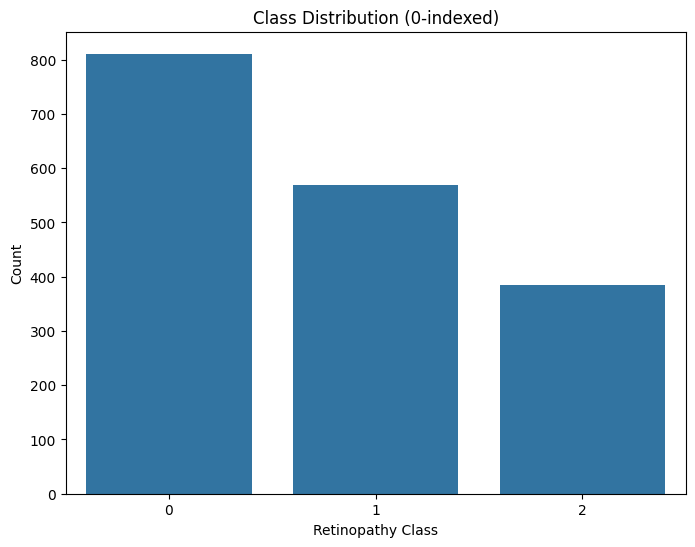

In [9]:
# Visualize Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='cat', data=df)
plt.title("Class Distribution (0-indexed)")
plt.xlabel("Retinopathy Class")
plt.ylabel("Count")
plt.show()

In [10]:
# Split Data into Training and Validation Sets
train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df['cat'], random_state=42)

# Data Preprocessing with Augmentation
image_size = (224, 224)
batch_size = 32

# Convert class labels to strings for flow_from_dataframe
train_df['cat'] = train_df['cat'].astype(str)
valid_df['cat'] = valid_df['cat'].astype(str)

In [12]:
# Calculate class weights for imbalanced data
class_counts = df['cat'].value_counts()
total_samples = class_counts.sum()
class_weights = {
    0: total_samples / (3 * class_counts[0]),  # Class 0
    1: total_samples / (3 * class_counts[1]),  # Class 1
    2: total_samples / (3 * class_counts[2])   # Class 2
}

In [14]:
#Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [15]:
# For validation - no augmentation
valid_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='cat',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

valid_gen = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='image_path',
    y_col='cat',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

Found 1411 validated image filenames belonging to 3 classes.
Found 353 validated image filenames belonging to 3 classes.


In [16]:
# Model Architecture - Using Transfer Learning with MobileNetV2
def create_model(input_shape=(224, 224, 3), num_classes=3):
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )

    # Freeze the base model
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

model = create_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    os.path.join(DATA_DIR, 'best_retinopathy_model.h5'),
    save_best_only=True,
    monitor='val_loss'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

In [18]:
# Train the model
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    callbacks=[early_stop, checkpoint, reduce_lr],
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.5320 - loss: 1.2338

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 674ms/step - accuracy: 0.5327 - loss: 1.2325 - val_accuracy: 0.4618 - val_loss: 0.9971 - learning_rate: 1.0000e-04
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.6497 - loss: 0.9393

45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 488ms/step - accuracy: 0.6500 - loss: 0.9394 - val_accuracy: 0.6006 - val_loss: 0.7967 - learning_rate: 1.0000e-04
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.6807 - loss: 0.9009

45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 447ms/step - accuracy: 0.6806 - loss: 0.9004 - val_accuracy: 0.7224 - val_loss: 0.6122 - learning_rate: 1.0000e-04
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.7065 - loss: 0.8515

45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 500ms/step - accuracy: 0.7065 - loss: 0.8511 - val_accuracy: 0.7677 - val_loss: 0.5294 - learning_rate: 1.0000e-04
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 648ms/step - accuracy: 0.7425 - loss: 0.7169 - val_accuracy: 0.7705 - val_loss: 0.5341 - learning_rate: 1.0000e-04
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.7512 - loss: 0.7438

45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 476ms/step - accuracy: 0.7509 - loss: 0.7441 - val_accuracy: 0.7790 - val_loss: 0.5183 - learning_rate: 1.0000e-04
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.6951 - loss: 0.8111

45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 446ms/step - accuracy: 0.6955 - loss: 0.8096 - val_accuracy: 0.7847 - val_loss: 0.4799 - learning_rate: 1.0000e-04
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 508ms/step - accuracy: 0.7446 - loss: 0.7550 - val_accuracy: 0.7875 - val_loss: 0.4917 - learning_rate: 1.0000e-04
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 438ms/step - accuracy: 0.7362 - loss: 0.7250 - val_accuracy: 0.7705 - val_loss: 0.5050 - learning_rate: 1.0000e-04
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.7492 - loss: 0.7112

45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 493ms/step - accuracy: 0.7490 - loss: 0.7106 - val_accuracy: 0.8130 - val_loss: 0.4542 - learning_rate: 1.0000e-04
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 469ms/step - accuracy: 0.7553 - loss: 0.6488 - val_accuracy: 0.8074 - val_loss: 0.4733 - learning_rate: 1.0000e-04
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 451ms/step - accuracy: 0.7463 - loss: 0.6442 - val_accuracy: 0.7960 - val_loss: 0.4748 - learning_rate: 1.0000e-04
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 501ms/step - accuracy: 0.7726 - loss: 0.6585 - val_accuracy: 0.7847 - val_loss: 0.4840 - learning_rate: 1.0000e-04
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 445ms/step - accuracy: 0.7618 - loss: 0.6373 - val_accuracy: 0.7705 - val_loss: 0.5161 - learning_rate: 1.0000e-04
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 475ms/step - accuracy: 0.7955 - loss: 0.5769 - val_accuracy: 0.7790 - val_loss: 0.5006 - learning_rate: 1.0000e-04
Epoch 16/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 442ms/step - accuracy

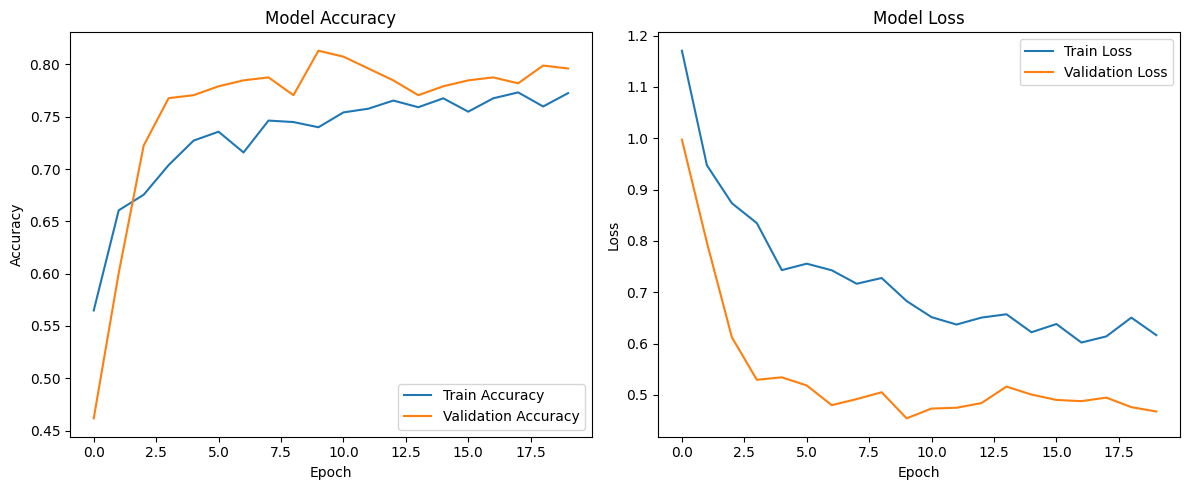

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 349ms/step

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      0.99      0.94       162
     Class 1       0.79      0.62      0.70       114
     Class 2       0.67      0.73      0.70        77

    accuracy                           0.81       353
   macro avg       0.78      0.78      0.78       353
weighted avg       0.81      0.81      0.81       353



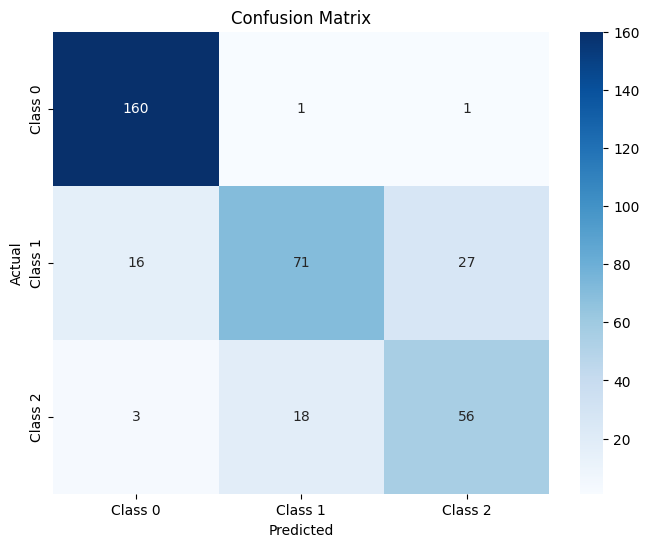


Weighted Metrics:
F1 Score: 0.8072
Precision: 0.8104
Recall: 0.8130
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - accuracy: 0.8173 - loss: 0.4776

Validation Accuracy: 0.8130
Validation Loss: 0.4542


In [19]:
# Save the final model
model.save(os.path.join(DATA_DIR, 'Retinopathy_model_final.h5'))

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

# Evaluate the model
model = load_model(os.path.join(DATA_DIR, 'Retinopathy_model_final.h5'))
valid_gen.reset()

# Get true labels and predictions
y_true = valid_gen.classes
y_pred = model.predict(valid_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Class 0', 'Class 1', 'Class 2']))

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred_classes),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate metrics
f1 = f1_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')

print("\nWeighted Metrics:")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Evaluate on validation set
loss, accuracy = model.evaluate(valid_gen)
print(f"\nValidation Accuracy: {accuracy:.4f}")
print(f"Validation Loss: {loss:.4f}")



=== Detailed Validation Evaluation ===
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.8173 - loss: 0.4776
Validation Accuracy: 0.8130
Validation Loss: 0.4542
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 337ms/step

Classification Report:
                       precision    recall  f1-score   support

      Class 0 (No DR)       0.89      0.99      0.94       162
    Class 1 (Mild DR)       0.79      0.62      0.70       114
Class 2 (Moderate DR)       0.67      0.73      0.70        77

             accuracy                           0.81       353
            macro avg       0.78      0.78      0.78       353
         weighted avg       0.81      0.81      0.81       353



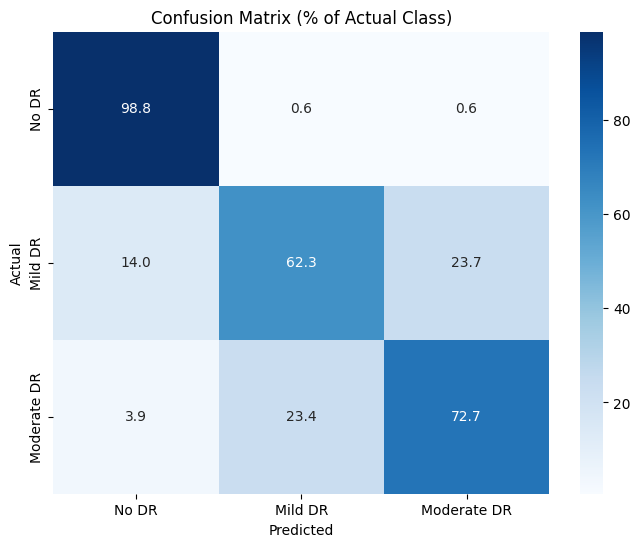


=== Sample Predictions ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


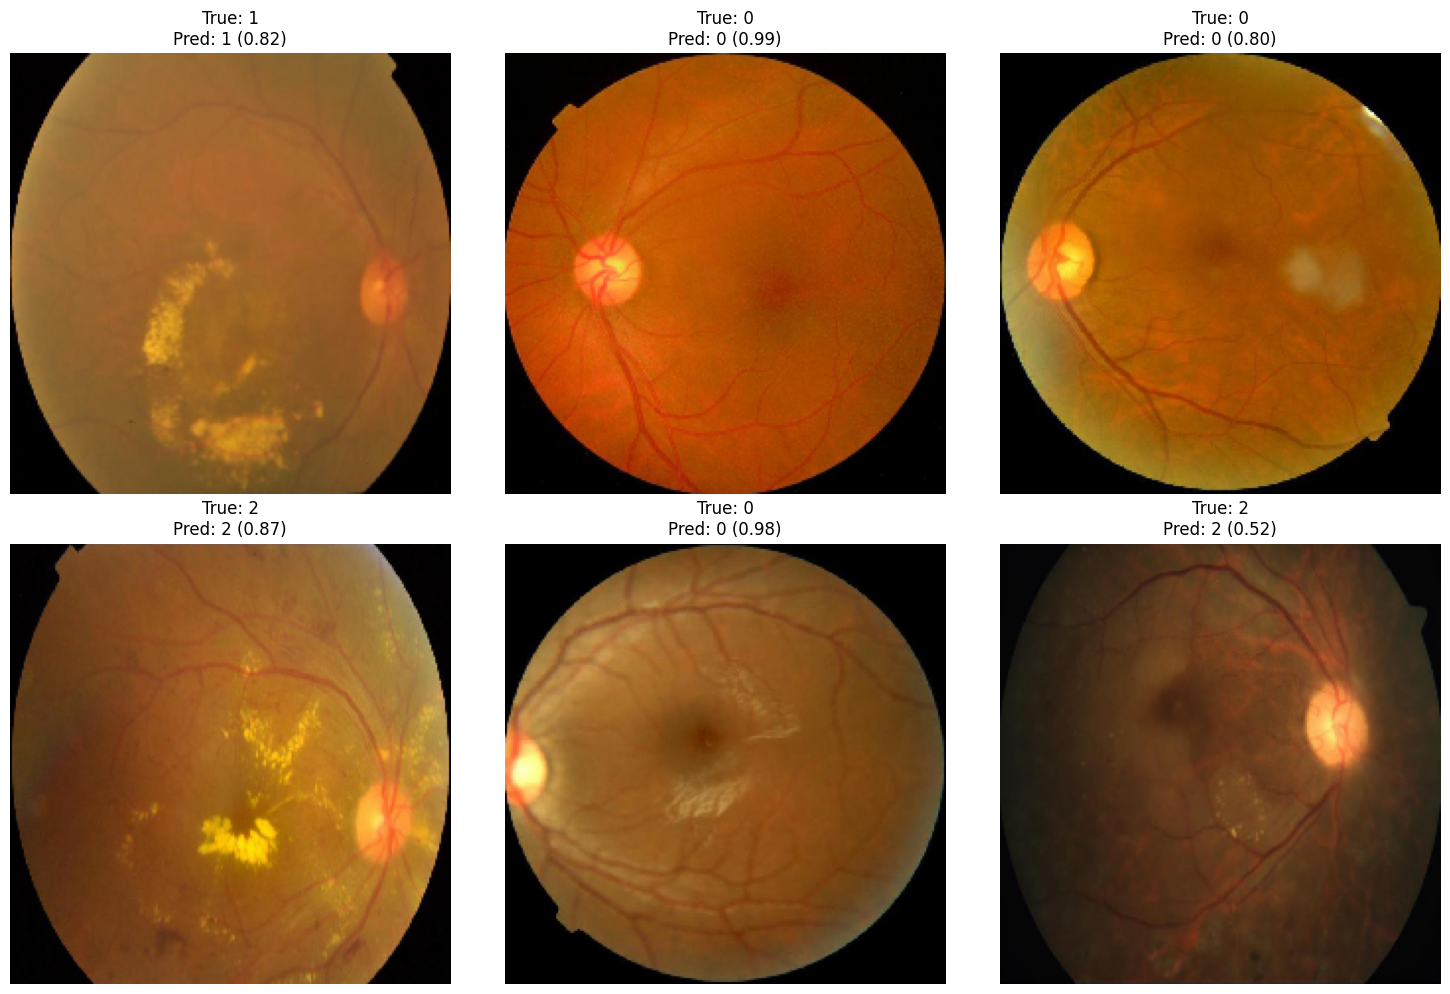

<Figure size 1000x500 with 0 Axes>

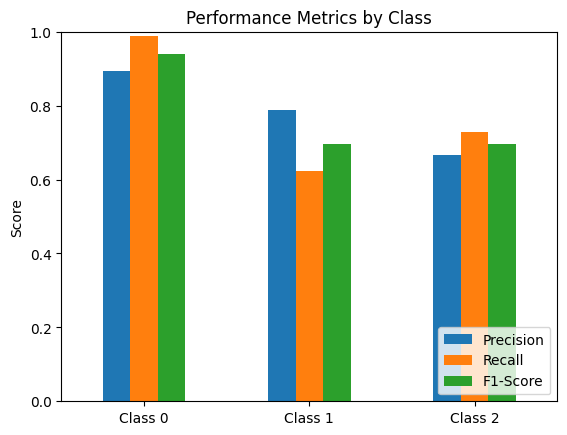

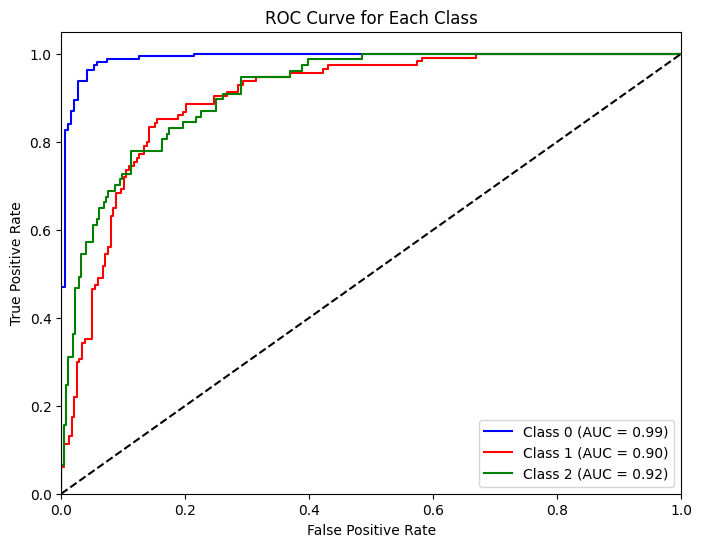

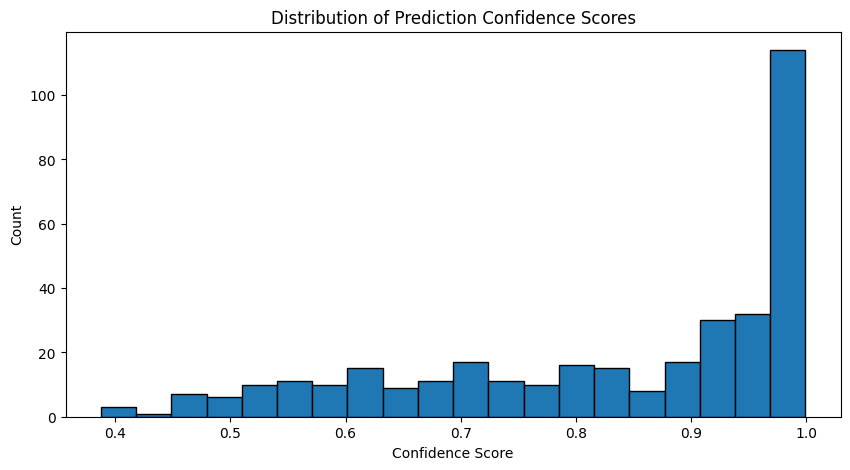


Most Confident Wrong Predictions:
     true  pred  confidence                                         image_path
63      1     0    0.987172  /content/retinopathy_data/images/o_c2t28640233...
123     1     2    0.973595  /content/retinopathy_data/images/o_c2t24999228...
2       1     2    0.950722  /content/retinopathy_data/images/o_c2t25284497...
221     1     0    0.927143  /content/retinopathy_data/images/o_c2t37241695...
352     1     2    0.922988  /content/retinopathy_data/images/o_c2t27182321...


In [20]:
# Load the best saved model
best_model = load_model(os.path.join(DATA_DIR, 'best_retinopathy_model.h5'))

## 1. Detailed Validation Evaluation
print("\n=== Detailed Validation Evaluation ===")
valid_gen.reset()
loss, accuracy = best_model.evaluate(valid_gen)
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Loss: {loss:.4f}")

# Get the full classification report
y_true = valid_gen.classes
y_pred = best_model.predict(valid_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes,
                          target_names=['Class 0 (No DR)', 'Class 1 (Mild DR)', 'Class 2 (Moderate DR)']))

# Confusion Matrix with percentages
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['No DR', 'Mild DR', 'Moderate DR'],
            yticklabels=['No DR', 'Mild DR', 'Moderate DR'])
plt.title('Confusion Matrix (% of Actual Class)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 2. Sample Predictions Visualization
def plot_sample_predictions(df, model, num_samples=6):
    plt.figure(figsize=(15, 10))
    samples = df.sample(num_samples)

    for i, (_, row) in enumerate(samples.iterrows()):
        img = tf.keras.preprocessing.image.load_img(row['image_path'], target_size=image_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)/255.0
        img_array = np.expand_dims(img_array, axis=0)

        pred = model.predict(img_array)
        predicted_class = np.argmax(pred)
        confidence = np.max(pred)

        true_class = int(row['cat'])

        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"True: {true_class}\nPred: {predicted_class} ({confidence:.2f})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\n=== Sample Predictions ===")
plot_sample_predictions(valid_df, best_model)

## 3. Performance Metrics by Class
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes, average=None)

plt.figure(figsize=(10, 5))
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}, index=['Class 0', 'Class 1', 'Class 2'])

metrics_df.plot(kind='bar', rot=0)
plt.title('Performance Metrics by Class')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

## 4. ROC Curve (for binary classification would be better, but shown for completeness)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the output
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

## 5. Prediction Confidence Analysis
confidences = np.max(y_pred, axis=1)
plt.figure(figsize=(10, 5))
plt.hist(confidences, bins=20, edgecolor='black')
plt.title('Distribution of Prediction Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.show()

## 6. Error Analysis - Most Confused Cases
error_df = pd.DataFrame({
    'true': y_true,
    'pred': y_pred_classes,
    'confidence': np.max(y_pred, axis=1),
    'image_path': valid_df['image_path'].values
})

# Get cases where model was wrong
wrong_predictions = error_df[error_df['true'] != error_df['pred']]
print("\nMost Confident Wrong Predictions:")
print(wrong_predictions.sort_values('confidence', ascending=False).head())